In [356]:
from selenium import webdriver
import pandas as pd
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import seaborn as sns

# 北京昌平地区买房租房价格数据爬取及分析

## Task 1：数据爬取
负责block：沙河

### 二手房网数据爬取

In [254]:
# 封装一个爬虫函数，便于后续重复调用
def scrape_data(base_url, start_page, end_page, class_name, tag_name):
    string_list = []
    #用edge浏览器打开目标网页
    driver=webdriver.Edge()
    url = base_url
    driver.get(url)
    #用for循环爬取目标范围内每一页的文本
    for page in range(start_page, end_page + 1): 
        table = driver.find_element('class name', class_name)
        dls = table.find_elements(By.TAG_NAME, tag_name)
        data = []
        
        for dl in dls:
            cells = dl.find_elements(By.TAG_NAME, 'dd')
            if cells:
                dl_data = [cell.text for cell in cells]
                data.append(dl_data)
        
        df = pd.DataFrame(data)
        string_list.append(df)
    
    return string_list

In [256]:
detail1 = scrape_data("https://esf.fang.com/house-a012-b02698/",1,20,'shop_list.shop_list_4','dl')

In [265]:
# 处理文本数据
string_list1 = detail1[0]
#在切分文本时，“双重验真”会导致每一列数据切割后无法对齐，所以需要用\n标记后再做切分
string_list1[0] = [s.replace("\n双重验真", "_双重验真", 1) for s in string_list2[0]]
df1=string_list1[0].str.split('\n',expand=True)
df2=string_list1[1].str.split('\n',expand=True)
df2.columns = ['总价(万)','单位价格(元/㎡)']
# 将分割后的数据按行拼接成一个二维表格
info1 = pd.concat([df1,df2],axis=1)

In [267]:
# 整理表格格式，数字数据都转换为float类型
info1['总价(万)'] = info1['总价(万)'].apply(lambda x:x[:-1])
info1['单位价格(元/㎡)'] = info1['单位价格(元/㎡)'].apply(lambda x:x[:-3])
info1[['总价(万)','单位价格(元/㎡)']]=info1[['总价(万)','单位价格(元/㎡)']].astype('float')
info1['面积(㎡)'] = info1['总价(万)']*10000/info1['单位价格(元/㎡)'].astype('float')
info1.head()

,0,1,2,3,4,5,6,7,8,9,10,总价(万),单位价格(元/㎡),面积(㎡)
0,碧水三期小独栋别墅 570平占地2200平毛坯仅此一套,独栋| 卧室：5个 | 570㎡ | 东向 |苏丽莉,碧水庄园,沙河-碧水庄园,满五,None,None,None,None,None,None,3800.0,66666.0,570.005700
1,北京玫瑰园别墅独栋带电梯客厅大挑空,独栋| 卧室：6个 | 237.85㎡ | 东向 |苏丽莉,北京玫瑰园,沙河-沙河镇北八达岭高速路22出口沙河镇小寨村,满五,None,None,None,None,None,None,2200.0,92495.0,237.850695
2,"保真!碧水庄园三期次临湖 独栋别墅,占地2535㎡",独栋| 卧室：6个 | 739.48㎡ | 东向 |苏丽莉,碧水庄园,沙河-碧水庄园,满五,None,None,None,None,None,None,3800.0,51387.0,739.486641
3,保真!碧水庄园 三期临湖B2户型 毛坯大独栋,独栋| 卧室：9个 | 758.17㎡ | 南向 |苏丽莉,碧水庄园,沙河-碧水庄园,满五,None,None,None,None,None,None,8000.0,105517.0,758.171669
4,碧水庄园3期 占地1500平 800万装修 挑空南客厅,独栋| 卧室：4个 | 314.06㎡ | 南向 |苏丽莉,碧水庄园,沙河-碧水庄园,满五,None,None,None,None,None,None,3600.0,114627.0,314.062132


In [275]:
# 将数据分析需要的部分单独导出
info_m1 = pd.DataFrame()
info_m1[['price','m2']] = info1[['单位价格(元/㎡)','面积(㎡)']]
info_m1['block'] = '北京昌平沙河'
info_m1.to_csv('沙河二手房价.csv', index=False)

### 租房网数据爬取

In [263]:
# 调用封装的爬虫函数，爬取租房信息
detail2 = scrape_data("https://zu.fang.com/house-a012-b02698/",1,20,'houseList','dl')

In [270]:
# 切分文本数据，整理为表格格式，数字数据都转换为float类型
string_list2 = pd.DataFrame(detail2[0])
info2 = string_list2[0].str.split('\n', n=3, expand=True)
info2[3] = '\n' + info2[3]
info2[[3, '月租价格(元/月)']] = info2[3].str.rsplit('\n', n=1, expand=True)
info2['月租价格(元/月)'] = info2['月租价格(元/月)'].apply(lambda x:x[:-3]).astype('float')
info2[['出租方式','出租区域','面积(㎡)','朝向']] = info2[1].str.rsplit('|', n=3, expand=True)
info2['面积(㎡)'] = info2['面积(㎡)'].apply(lambda x:x[:-1]).astype('float')
info2['单位月租价格(元/月/㎡)'] = info2['月租价格(元/月)']/info2['面积(㎡)']
info2 = info2.drop(columns=[1])
info2.head()

,0,2,3,月租价格(元/月),出租方式,出租区域,面积(㎡),朝向,单位月租价格(元/月/㎡)
0,开间整租 独门独户 独立厨卫 家具齐全交通便捷 小区,昌平-沙河-北街家园五区,\n交通便利独门独卫采光好,2300.0,整租,1室1厅,36.0,朝东南,63.888889
1,"花合租的钱住整租一间,有独立洗手间",昌平-沙河-高教大楼,\n距昌平线沙河高教园站约1119米。\n可注册办公首次出租南北通透,1050.0,整租,1室0厅,18.0,朝西南,58.333333
2,昌平沙河高教园 独门独卫有电梯 家具齐全随时看 拎包,昌平-沙河-高教大楼,\n距昌平线沙河高教园站约1119米。\n可注册办公首次出租南北通透,2300.0,整租,1室0厅,36.0,朝东南,63.888889
3,"西二旗上地清河,优选公寓一居,非合租 月付 租期灵活",昌平-沙河-高教大楼,\n距昌平线沙河高教园站约1119米。\n周边配套齐独门独卫采光好,1200.0,整租,1室0厅,18.0,朝南北,66.666667
4,正南 北京玫瑰园 5室3厅 精装修,昌平-沙河-北京玫瑰园,,22000.0,整租,5室3厅,233.0,朝南,94.420601


In [277]:
# 将数据分析需要的部分单独导出
info_m2 = pd.DataFrame()
info_m2[['rent','m2']] = info2[['单位月租价格(元/月/㎡)','面积(㎡)']]
info_m2['block'] = '北京昌平沙河'
info_m2.to_csv('沙河租房租金.csv', index=False)

## Task 2：data description 以及寻找outlier

### -沙河二手房价数据

In [180]:
info1.describe()

,总价(万),单位价格(元/㎡),面积(㎡)
count,60.00000,60.0000,60.000000
mean,2364.70000,61154.2000,387.092639
std,1491.80411,19287.3591,214.701979
min,230.00000,30164.0000,57.001239
25%,1387.50000,46921.5000,257.246784
50%,2290.00000,56216.5000,353.663771
75%,3020.00000,71205.5000,565.496796
max,8000.00000,114627.0000,768.795602


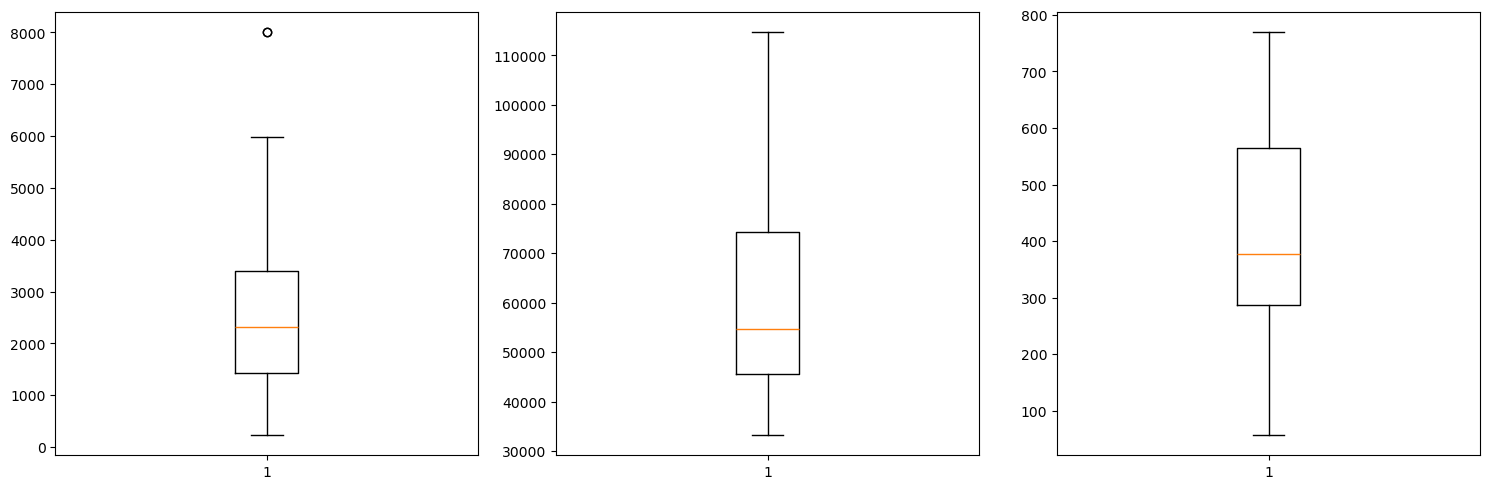

In [299]:
#用箱线图判断是否存在异常值
plot_list1 = ['总价(万)','单位价格(元/㎡)','面积(㎡)']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(plot_list1):
    axes[i].boxplot(info1[column]) 
plt.tight_layout()
plt.show()

观察图象得，总价有1个异常大的离群值，单位价格和面积均无异常值。

### -沙河租房租金数据

In [297]:
info2.describe()

,月租价格(元/月),面积(㎡),单位月租价格(元/月/㎡)
count,60.000000,60.000000,60.000000
mean,2822.500000,50.766667,57.337515
std,5524.241071,104.393384,9.724986
min,1000.000000,15.000000,35.714286
25%,1000.000000,18.000000,55.555556
50%,1000.000000,18.000000,55.555556
75%,1225.000000,20.750000,57.440476
max,25000.000000,545.000000,96.153846


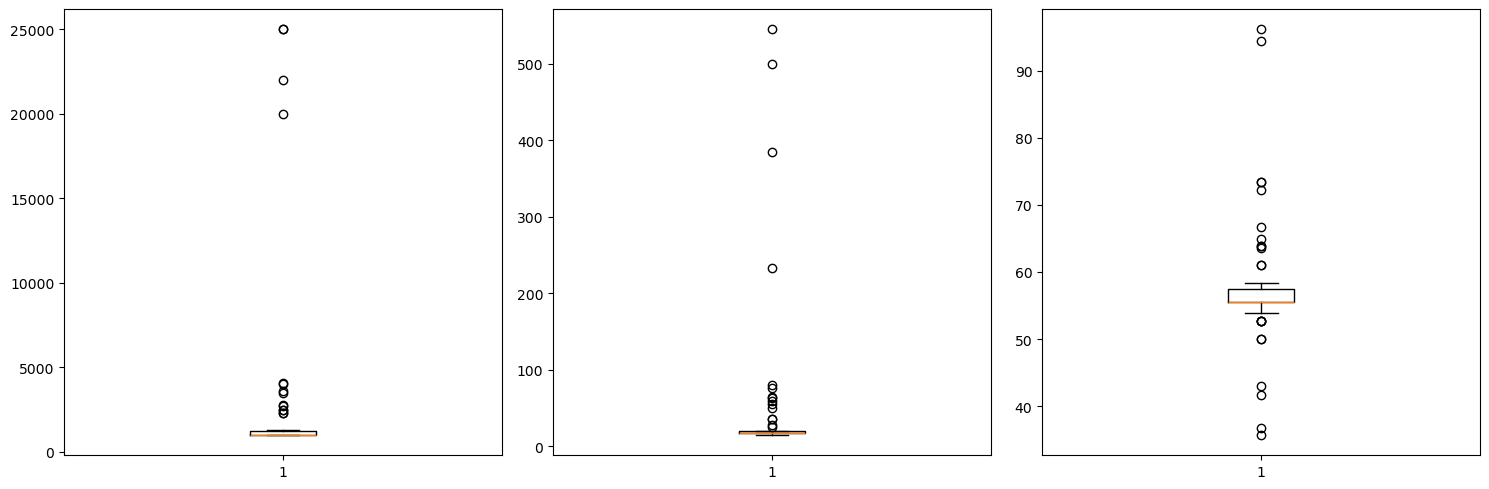

In [301]:
#用箱线图判断是否存在异常值
plot_list2 = ['月租价格(元/月)','面积(㎡)','单位月租价格(元/月/㎡)']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(plot_list2):
    axes[i].boxplot(info2[column]) 
plt.tight_layout()
plt.show()

观察图象得，月租价格，面积和单位月租价格都存在较多离群值。
初步猜测可能由于沙河地区合租和整租的房源都较多，而这二者在面积和租金上的差别都较大。

## Task 3：计算房价租金比并且绘制Figure A

In [309]:
# 用数据description table中的中位数进行计算: 房价租金比 = 房价中位数/年租金中位数
# 沙河地区：
ratio1 = 56216.5000/(55.555556*12)
# 同伴爬取的霍营地区：
ratio2 = 40.558456790359486
print(ratio1, ratio2)

84.324749325402 40.558456790359486


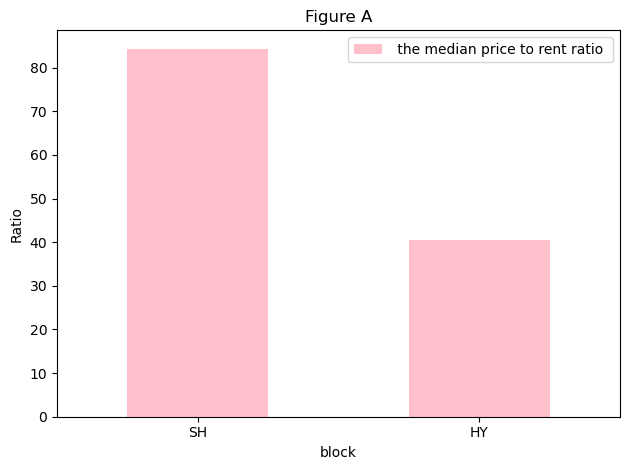

In [311]:
# 绘制两个房价租金比的柱形图
Ratio = {'Category': ['SH', 'HY'],
        ' the median price to rent ratio ': [ratio1, ratio2]}
Ratio = pd.DataFrame(Ratio)
Ratio.plot(kind='bar', x='Category', y=' the median price to rent ratio ', color='pink')

plt.title('Figure A')
plt.xlabel('block')
plt.ylabel('Ratio')
plt.xticks(rotation=0) 
plt.tight_layout() 
plt.show()

## Task 4：建立回归模型、尝试预测并绘制Figure B&C

### -二手房价模型

In [331]:
# 导入同伴爬取的霍营二手房价数据
info_m1_2 = pd.read_csv('霍营二手房价.csv')
info_m1_2 = pd.DataFrame(info_m1_2)
# 将霍营和沙河的数据合并为一个二维表格
info_price = pd.concat([info_m1, info_m1_2], ignore_index = True)
print(info_price)

        price          m2   block
0     66666.0  570.005700  北京昌平沙河
1     92495.0  237.850695  北京昌平沙河
2     51387.0  739.486641  北京昌平沙河
3    105517.0  758.171669  北京昌平沙河
4    114627.0  314.062132  北京昌平沙河
..        ...         ...     ...
115   47339.0   88.720000  北京昌平霍营
116   43911.0   85.400000  北京昌平霍营
117   43211.0  150.190000  北京昌平霍营
118   48701.0   92.400000  北京昌平霍营
119   43462.0   56.370000  北京昌平霍营

[120 rows x 3 columns]


In [333]:
# 对分类变量'block'进行独热编码
info_price = pd.get_dummies(info_price,columns=['block'],drop_first=True,dtype=int)
print(info_price)

        price          m2  block_北京昌平霍营
0     66666.0  570.005700             0
1     92495.0  237.850695             0
2     51387.0  739.486641             0
3    105517.0  758.171669             0
4    114627.0  314.062132             0
..        ...         ...           ...
115   47339.0   88.720000             1
116   43911.0   85.400000             1
117   43211.0  150.190000             1
118   48701.0   92.400000             1
119   43462.0   56.370000             1

[120 rows x 3 columns]


In [340]:
# 开始跑回归
model1 = smf.ols(formula='price ~ m2 + block_北京昌平霍营 + m2:block_北京昌平霍营', data=info_price).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6.113
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           0.000675
Time:                        11:38:40   Log-Likelihood:                -1332.2
No. Observations:                 120   AIC:                             2672.
Df Residuals:                     116   BIC:                             2684.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.781e+04   5081.410     

In [351]:
#对m2=50、m2=100的情况展开预测
predict_m1 = pd.DataFrame()
predict_m1[['m2','block_北京昌平霍营']]=[[50,1]]
predict_m1.loc[len(predict_m1.index)] = [50,0]
predict_m1.loc[len(predict_m1.index)] = [100,1]
predict_m1.loc[len(predict_m1.index)] = [100,0]
pre1_result = model1.predict(predict_m1)
#以二维表格形式输出
m1_result = pd.concat([predict_m1,pre1_result],axis=1)
m1_result.columns = ['m2','block','price/m2']
m1_result

,m2,block,price/m2
0,50,1,44370.559520
1,50,0,58178.050415
2,100,1,48781.185837
3,100,0,58545.093234


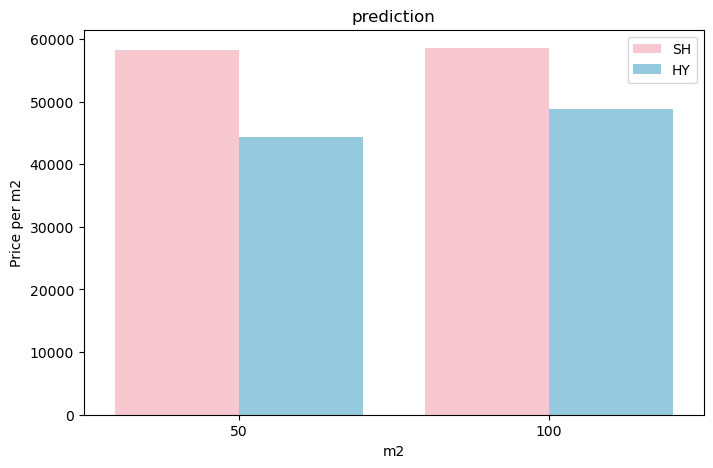

In [364]:
# 以柱形图形式输出
plt.figure(figsize=(8, 5))
plot_pre = sns.barplot(x='m2', y='price/m2', hue='block', data=m1_result, palette=['pink','skyblue'])
plt.xlabel("m2")
plt.ylabel("Price per m2")
plt.title("prediction")
handles, labels = plot_pre.get_legend_handles_labels()
plt.legend(handles,["SH", "HY"])
plt.show()

### -租房租金模型

In [397]:
# 导入同伴爬取的霍营租房租金数据
info_m2_2 = pd.read_csv('霍营租房租金.csv')
info_m2_2 = pd.DataFrame(info_m2_2)
# 将霍营和沙河的数据合并为一个二维表格
info_rent = pd.concat([info_m2, info_m2_2], ignore_index = True)
print(info_rent)

           rent     m2   block
0     63.888889   36.0  北京昌平沙河
1     58.333333   18.0  北京昌平沙河
2     63.888889   36.0  北京昌平沙河
3     66.666667   18.0  北京昌平沙河
4     94.420601  233.0  北京昌平沙河
..          ...    ...     ...
111   57.291667   96.0  北京昌平霍营
112   94.117647   17.0  北京昌平霍营
113  165.000000   20.0  北京昌平霍营
114   92.307692   52.0  北京昌平霍营
115   60.674157   89.0  北京昌平霍营

[116 rows x 3 columns]


In [399]:
# 对分类变量'block'进行独热编码
info_rent = pd.get_dummies(info_rent,columns=['block'],drop_first=True,dtype=int)
print(info_rent)

           rent     m2  block_北京昌平霍营
0     63.888889   36.0             0
1     58.333333   18.0             0
2     63.888889   36.0             0
3     66.666667   18.0             0
4     94.420601  233.0             0
..          ...    ...           ...
111   57.291667   96.0             1
112   94.117647   17.0             1
113  165.000000   20.0             1
114   92.307692   52.0             1
115   60.674157   89.0             1

[116 rows x 3 columns]


In [401]:
# 开始跑回归
model2 = smf.ols(formula='rent ~ m2 + block_北京昌平霍营 + m2:block_北京昌平霍营', data=info_rent).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     60.37
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           2.70e-23
Time:                        12:12:39   Log-Likelihood:                -504.84
No. Observations:                 116   AIC:                             1018.
Df Residuals:                     112   BIC:                             1029.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          57.7560      2.749     

In [403]:
#对m2=50、m2=100的情况展开预测
predict_m2 = pd.DataFrame()
predict_m2[['m2','block_北京昌平霍营']]=[[50,1]]
predict_m2.loc[len(predict_m2.index)] = [50,0]
predict_m2.loc[len(predict_m2.index)] = [100,1]
predict_m2.loc[len(predict_m2.index)] = [100,0]
pre2_result = model2.predict(predict_m2)
#以二维表格形式输出
m2_result = pd.concat([predict_m2,pre2_result],axis=1)
m2_result.columns = ['m2','block','rent/m2']
m2_result

,m2,block,rent/m2
0,50,1,82.500854
1,50,0,57.343834
2,100,1,42.250163
3,100,0,56.931686


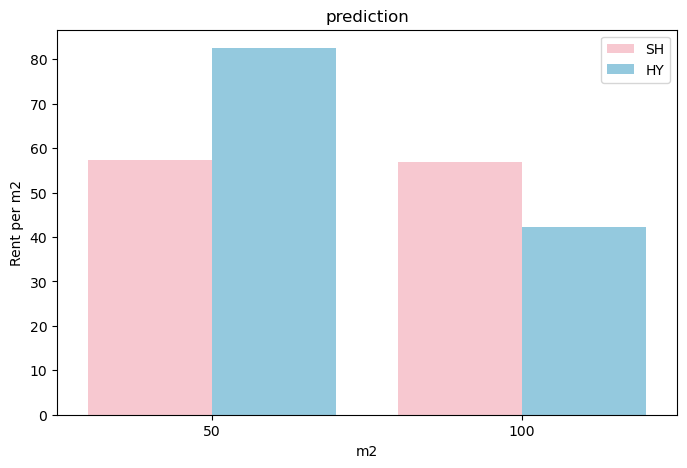

In [405]:
# 以柱形图形式输出
plt.figure(figsize=(8, 5))
plot_pre = sns.barplot(x='m2', y='rent/m2', hue='block', data=m2_result, palette=['pink','skyblue'])
plt.xlabel("m2")
plt.ylabel("Rent per m2")
plt.title("prediction")
handles, labels = plot_pre.get_legend_handles_labels()
plt.legend(handles,["SH", "HY"])
plt.show()

### -绘制Figure B&C

In [409]:
# 直接导入
rr_result = pd.concat([pre1_result,pre2_result],axis=1,ignore_index=True)
rr_result.columns = ['price/m2','rent/m2']
rr_result['rent ratio'] = rr_result['price/m2']/(rr_result['rent/m2']*12)
rr_result

,price/m2,rent/m2,rent ratio
0,44370.559520,82.500854,44.818283
1,58178.050415,57.343834,84.545635
2,48781.185837,42.250163,96.214985
3,58545.093234,56.931686,85.694947


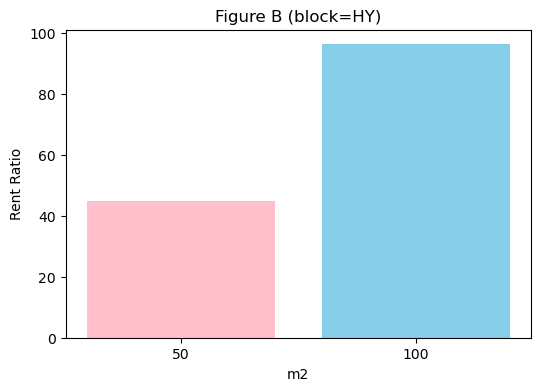

In [416]:
# 绘制Figure B：霍营的房价租金比
rr2 = pd.DataFrame({'m2': ['50', '100'], 'rent_ratio': [44.818283, 96.214985]})
plt.figure(figsize=(6, 4))
plt.bar(rr2['m2'], rr2['rent_ratio'], color=['pink', 'skyblue'])
plt.xlabel("m2")
plt.ylabel("Rent Ratio")
plt.title("Figure B (block=HY)")
plt.show()

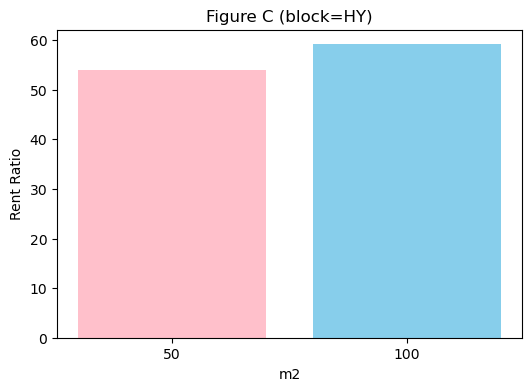

In [422]:
# 绘制Figure C：沙河的房价租金比
rr3 = pd.DataFrame({'m2': ['50', '100'], 'rent_ratio': [54.086457, 59.153630]})
plt.figure(figsize=(6, 4))
plt.bar(rr3['m2'], rr3['rent_ratio'], color=['pink', 'skyblue'])
plt.xlabel("m2")
plt.ylabel("Rent Ratio")
plt.title("Figure C (block=HY)")
plt.show()